# Lipschitz constant of NNs

## Imports

In [1]:
import os
from pathlib import Path

import json

from copy import copy
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
env_name = "halfcheetah_v3"
env_dir = Path(os.getcwd()).parent / "benchmark" / env_name
os.chdir(env_dir) 
os.getcwd()

'/home/abenechehab/rl_simulator/benchmark/halfcheetah_v3'

## Loading data fn

In [3]:
metadata_path = Path("data") / "metadata.json"
with open(metadata_path, "r") as json_file:
    metadata = json.load(json_file)

_target_column_observation_names = metadata["observation"]
_target_column_action_names = metadata["action"]
_restart_name = metadata["restart_name"]

n_obs = len(_target_column_observation_names)
n_actions = len(_target_column_action_names)

In [4]:
def _read_data(
    path,
    X_name,
    data_label="",
    horizon=1,
    dataframe=False,
    dynamic=False,
    return_reward=False,
):
    """Reading and preprocessing data.
    ************* Changes with respect to master *************
    * Handles multitimestep models by creating the correct data format

    Parameters
    ----------
    path : string
        Data directory.

    X_name : string
        Name of the csv data file. This data file contains a sequence of
        observations and action. Each sample/row is assumed to contain one
        observation and one action, the action being the one selected after
        the observation. Each row also contains a flag (the restart column)
        equal to 1 if the sequence has been reset with a new random
        observation, 0 otherwise. Finally each row preceding a restart is
        assumed to contain the last observation of the sequence, the one
        obtained just before the sequence was reset, and a NaN value for
        the associated action.

    data_label : string
        Subfolder in /data where X_name is. Also used for creating
        subdirectories in /submissions/<submission>/training_output
        if --save-output is specified.

    horizon: int
        horizon for which the model will be trained (and the data will be formatted accordingly)

    Return
    ------
    X_df : pandas DataFrame
        Preprocessed data. Same format as the original data file but with
        targets appended. Each row thus contains a transition
        (past observation, action, new observation). Indeed, as the chaining
        rule is used, when training/testing the model the feature p - 1 of the
        target is needed to predict feature p of the target.

    y_array : numpy array, shape (n_samples,)
        Targets. The targets are the observations following the action
        contained in each row of the input data file.
    """
    # start_time = time.time()

    if data_label == "":
        X_df = pd.read_csv(os.path.join(path, "data", X_name))
    else:
        X_df = pd.read_csv(os.path.join(path, "data", data_label, X_name))
    # log_time(start_time, task_name=f'read data')

    # make sure that we have float for action because of check_ds...
    X_df = X_df.astype({_target_column_action_names[0]: "float"})
    X_df = X_df.astype({_restart_name: "int64"})

    rewards = X_df.iloc[:-1]["reward"]

    # reorder columns according to _target_column_observation_names
    X_df = X_df.reindex(
        columns=_target_column_observation_names
        + _target_column_action_names
        + [_restart_name]
    )
    # Target for observation
    y_df = X_df[_target_column_observation_names].iloc[1:]
    y_df.reset_index(drop=True, inplace=True)

    # We drop the last step of X since we do not have data
    # for a(t) at last timestep
    X_df = X_df.iloc[:-1]
    date = X_df.index.copy()

    if dynamic:
        extra_truth_dict = {}
        extra_truth_all = []
        for h in range(1, horizon + 1):
            extra_truth_dict[str(h)] = [
                "y_" + name + f"_{h}" for name in _target_column_observation_names
            ]
            extra_truth_all += extra_truth_dict[str(h)]

    # Since in validation we will need to gradually give y to the
    # conditional regressor, we now have to add y in X.
    extra_truth = ["y_" + obs for obs in _target_column_observation_names]
    columns_X = list(X_df.columns)

    y_df_no_name = pd.DataFrame(y_df.values)
    X_df.reset_index(drop=True, inplace=True)
    X_df = pd.concat([X_df, y_df_no_name], axis=1)

    new_names = columns_X + extra_truth
    X_df = X_df.set_axis(new_names, axis=1)

    X_df.set_index(date, inplace=True)
    X_df.dropna(how="any", inplace=True)

    # log_time(start_time, task_name=f'previous pre-processing')

    # ======================== Multi-timestep ===========================
    X_df_m = X_df.copy()
    if horizon > 1:
        # action column names for different horizons
        _target_column_action_names_dict = {}
        # create new_columns to change the order of the columns at the end
        new_columns = _target_column_observation_names.copy()
        new_action_columns = []
        for h in range(horizon):
            _target_column_action_names_dict[str(h)] = [
                name + f"_{h}" for name in _target_column_action_names
            ]
            # _target_column_action_names_0 = [name + '_0' for name in _target_column_action_names]
            new_action_columns += _target_column_action_names_dict[str(h)]
        new_columns += new_action_columns
        # log_time(start_time, task_name=f'[multistep] define new columns')

        X_df_m = X_df_m.rename(
            columns={
                name: _target_column_action_names_dict["0"][i]
                for (i, name) in enumerate(_target_column_action_names)
            }
        )

        # log_time(start_time, task_name=f'[multistep] renaming')

        # set some useful counting variables
        n_actions = len(_target_column_action_names)
        n_observations = len(_target_column_observation_names)
        n_samples = len(X_df_m)
        n_columns = len(X_df_m.columns)
        n_new_action_columns = len(new_action_columns[n_actions:])

        # We will switch to numpy arrays because it's much faster to fill new columns
        # augment the np array with the new actions columns with default values 0.0
        X_df_m_np = np.concatenate(
            [X_df_m.to_numpy(), np.zeros((n_samples, n_new_action_columns))], axis=1
        )

        for h in range(1, horizon):
            target_start_col_index = (
                n_columns + (h - 1) * n_actions
            )  # starting column index for horizon 'h' action
            target_end_col_index = (
                target_start_col_index + n_actions
            )  # ending column index horizon 'h' action
            source_start_col_index = n_observations  # because the actions are located right after the observations
            source_end_col_index = n_observations + n_actions
            # for the first 'n_samples-h' samples, set the values of the horizon 'h' action
            X_df_m_np[
                : n_samples - h, target_start_col_index:target_end_col_index
            ] = X_df_m_np[h:, source_start_col_index:source_end_col_index]

        # log_time(start_time, task_name=f'[multistep] set new columns values')

        # go back to pd dataframe object with the correct column names
        X_df_m = pd.DataFrame(
            X_df_m_np, columns=X_df_m.columns.to_list() + new_action_columns[n_actions:]
        )

        # Change the target to corresponding future horizon state
        # (append zeros at the end for the vacant positions, they will be removed later anyway)
        if dynamic:
            for h in range(1, horizon + 1):
                X_df_m[extra_truth_dict[str(h)]] = np.concatenate(
                    [
                        X_df_m.iloc[h - 1 :][extra_truth].to_numpy(),
                        np.zeros((h - 1, len(extra_truth))),
                    ],
                    axis=0,
                )
            extra_truth = extra_truth_all
        else:
            X_df_m[extra_truth] = np.concatenate(
                [
                    X_df_m.iloc[horizon - 1 :][extra_truth].to_numpy(),
                    np.zeros((horizon - 1, len(extra_truth))),
                ],
                axis=0,
            )

        # remove artifacts from the end of episodes where two states from different episodes will be in the same
        # datapoint
        restart = X_df_m["restart"].to_numpy().astype("bool")
        condition = restart
        for _ in range(1, horizon):
            # translate cond by -1 for every step in the future that we foresee (because the artifact occurs before the
            # location where restart=1)
            condition = condition[1:] | condition[:-1]
        # log_time(start_time, task_name=f'[multistep] loop to find restart-related condition')

        # set to True only the elements where an artifact occurs (XOR operator)
        condition = condition ^ restart[: -(horizon - 1)]

        # remove these edge cases along with the last elements of X_df_m which have zeros due to absent data
        X_df_m = X_df_m.iloc[: -(horizon - 1)].loc[~condition]

        # log_time(start_time, task_name=f'[multistep] filtering')

        # rearrange columns to have actions next to each others after the state s0
        new_columns += [_restart_name] + extra_truth
        X_df_m = X_df_m[new_columns]
    # ==============================================================
    if dataframe:
        if return_reward:
            return X_df_m, X_df_m[extra_truth], rewards
        else:
            return X_df_m, X_df_m[extra_truth]
    else:
        return X_df_m.to_numpy().astype("float32"), X_df_m[
            extra_truth
        ].to_numpy().astype("float32")


def get_train_data(
    path=".",
    data_label="",
    file_name="X_train.csv",
    horizon=1,
    dataframe=False,
    dynamic=False,
    return_reward=False,
):
    return _read_data(
        path,
        file_name,
        data_label,
        horizon=horizon,
        dataframe=dataframe,
        dynamic=dynamic,
        return_reward=return_reward,
    )


def get_test_data(
    path=".",
    data_label="",
    file_name="X_test.csv",
    horizon=1,
    dataframe=False,
    dynamic=False,
    return_reward=False,
):
    return _read_data(
        path,
        file_name,
        data_label,
        horizon=horizon,
        dataframe=dataframe,
        dynamic=dynamic,
        return_reward=return_reward,
    )

## Model

In [22]:
class SmallModel(nn.Module):
    def __init__(
        self,
        input_dim: int = 1,
        output_dim: int = 1,
        layer_size: int = 1,
        n_layers: int = 1,
        skip_connection: bool = False,
        activation: nn.modules.activation.Module = nn.ReLU,
    ):
        super(SmallModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.skip_connection = skip_connection

        self.linear0 = nn.Linear(input_dim, layer_size, bias=True)
        self.act0 = activation()

        self.common_block = nn.Sequential()
        for i in range(int(n_layers)):
            self.common_block.add_module(
                f"linear{i+1}", nn.Linear(layer_size, layer_size)
            )
            self.common_block.add_module(f"act{i+1}", activation())

        self.mu = nn.Linear(layer_size, output_dim, bias=True)

    def forward(self, x):
        n_samples = x.shape[0]

        skip_connection_x = copy(x).detach()[:, :self.output_dim]

        x = self.linear0(x)
        x = self.act0(x)
        x = self.common_block(x)
        mu = self.mu(x)

        if self.skip_connection:
            mu += skip_connection_x

        return mu

## save initial weights

In [24]:
# ---------- device ----------
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

input_dim = len(_target_column_observation_names) + len(_target_column_action_names)
output_dim = len(_target_column_observation_names)
layer_size = 256
n_layers = 2
skip_connection = False
activation = nn.Tanh

model = SmallModel(
    input_dim = input_dim,
    output_dim = output_dim,
    layer_size = layer_size,
    n_layers = n_layers,
    skip_connection = skip_connection,
    activation=activation
).to(device=device)
state_dict = model.state_dict()
if not Path('artifacts').exists():
    os.makedirs(Path('artifacts'))
torch.save(state_dict, 'artifacts/save_init_weights.pt')

## Helper functions

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
def forward_future_horizon(model, x, horizon=1, n_obs=n_obs, n_actions=n_actions):
    obs = x[:,:n_obs]
    for h in range(horizon):
        action = x[:,n_obs+h*n_actions:n_obs+(h+1)*n_actions]
        input_state = torch.cat([obs, action], dim=1)
        obs = model(input_state)
    return obs

def max_gradient(model, x, horizon):
    model.eval()  # Set the model to evaluation mode
    x.requires_grad_(True)  # Set requires_grad to True for input x
    output = forward_future_horizon(model, x, horizon=horizon)  # Forward pass to get the model output
    grad = torch.autograd.grad(torch.mean(output), x)[0]  # Compute gradients of output w.r.t. input x
    max_grad = grad.abs().max()  # Compute the maximum absolute gradient
    return max_grad.item()  # Return the maximum gradient value as a scalar

def beta_multi_step_loss(model, loss_fn, x, y, horizon=1, n_obs=n_obs, n_actions=n_actions, beta=1.0):
    obs = x[:,:n_obs]
    loss_local = None
    sum_weights = 0
    for h in range(horizon):
        action = x[:,n_obs+h*n_actions:n_obs+(h+1)*n_actions]
        input_state = torch.cat([obs, action], dim=1)
        obs = model(input_state)
        target = y[:, n_obs*h:n_obs*(h+1)]
        loss_local = beta * loss_fn(obs, target) if h==0 else loss_local + loss_fn(obs, target)*(beta**(h+1))
        sum_weights += beta**(h+1)
    return loss_local / sum_weights

## Hyperparameters

In [32]:
# ---------- device ----------
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

learning_rate = 0.001
loss_fn = nn.MSELoss()

data_label = 'd4rl_expert_80k_20k'

keep_best_val = True

# ---------- trainer hypers ----------
batch_size = 256
max_loss_horizon = 1
n_epochs = 300
r2_test_max_horizon = 100
frequency_test = 100
simulation_episode_index = 0
validation_fraction = 0.2
n_folds = 1

## Training loop

In [33]:
# ---------- init df ----------
columns=['fold', 'epoch', 'loss_horizon', 'beta', 'train_loss', 'valid_loss', 'max_grad_train', 'max_grad_test', 'max_grad_random', 'spectral']
columns += [f'r2_test_h_{i}' for i in range(1,r2_test_max_horizon-1)]
df_lines=[]

# ---------- Load and setup X_test ----------
X_test, y_test = get_test_data(data_label=data_label, horizon=100, dynamic=True)
dataset_test_r2 = torch.utils.data.TensorDataset(torch.from_numpy(X_test))
dataset_test_r2 = torch.utils.data.DataLoader(
    dataset_test_r2,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)
X_test_sim, _ = get_test_data(data_label=data_label)
dataset_test = torch.utils.data.TensorDataset(torch.from_numpy(X_test_sim))
dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

# ---------- random dataset ----------
X_random = np.random.uniform(np.min(X_test[:,:input_dim], axis=0), np.max(X_test[:,:input_dim], axis=0), (10000,input_dim)).astype('float32')
dataset_random = torch.utils.data.TensorDataset(torch.from_numpy(X_random))
dataset_random = torch.utils.data.DataLoader(
    dataset_random,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
)

all_predictions = {}
groundtruth = None
for loss_horizon in tqdm(range(1, max_loss_horizon+1), desc='loss_horizon'):
    print(f"loss_horizon: {loss_horizon}")

    # ---------- load data ----------
    X_train, y_train = get_train_data(data_label=data_label, horizon=loss_horizon, dynamic=True)
    X_train = X_train[:,:(n_obs+loss_horizon*n_actions)]
    
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    
    betas = [1.0] if loss_horizon==1 else [0.1, 0.25, 0.5, 0.75, 1.0, 5.0, 10.0]
    for beta in tqdm(betas, desc='beta'):
        print(f"beta: {beta}")
    
        for fold in tqdm(range(1, n_folds+1), desc='folds'):    
            # ---------- train/valid split ----------
            n_samples = len(dataset)
            
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            
            ind_split = int(np.floor((1 - validation_fraction) * n_samples))
            train_indices, val_indices = indices[:ind_split], indices[ind_split:]
            
            dataset_valid = torch.utils.data.TensorDataset(*dataset[val_indices])
            dataset_train = torch.utils.data.TensorDataset(*dataset[train_indices])
            
            dataset_train = torch.utils.data.DataLoader(
                dataset_train,
                batch_size=batch_size,
                shuffle=True,
                drop_last=False,
            )
            dataset_valid = torch.utils.data.DataLoader(
                dataset_valid, batch_size=64, shuffle=False
            )
            
            n_train = len(dataset_train.dataset)
            n_valid = len(dataset_valid.dataset)
            # ---------- init model ----------
            model = SmallModel(
                input_dim = input_dim,
                output_dim = output_dim,
                layer_size = layer_size,
                n_layers = n_layers,
                skip_connection = skip_connection
            ).to(device=device)
            loaded_state_dict = torch.load('artifacts/save_init_weights.pt')
            model.load_state_dict(loaded_state_dict)

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, 'min', factor=0.1, patience=30, cooldown=20,
                min_lr=1e-7, verbose=False
            )
            
            # ---------- training loop ----------
            best_val_loss = float(1e6)
            for epoch in tqdm(range(1, 1+n_epochs), desc='training epochs'):
                model.train()
                train_loss = 0
                max_grad = 0
                # ---------- training ----------
                for i, (x, y) in enumerate(dataset_train):
                    model.zero_grad()
                    loss = beta_multi_step_loss(
                        model=model,
                        loss_fn=loss_fn,
                        x=x.to(device=device),
                        y=y.to(device=device),
                        horizon=loss_horizon,
                        beta=beta
                    )
                    train_loss += len(x) * loss.item()
                    loss.backward()
                    optimizer.step()

                    # ---------- Lipschitz constant ----------
                    max_grad_batch = max_gradient(model=model, x=x[:,:input_dim].to(device=device), horizon=1)
                    if max_grad_batch > max_grad:
                        max_grad = max_grad_batch
    
                train_loss /= n_train
    
                # ---------- validation ----------
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for _, (x, y) in enumerate(dataset_valid):
                        loss = beta_multi_step_loss(
                            model=model,
                            loss_fn=loss_fn,
                            x=x.to(device=device),
                            y=y.to(device=device),
                            horizon=loss_horizon,
                            beta=beta
                        )
                        val_loss += len(x) * loss.item()
                val_loss /= n_valid
                scheduler.step(val_loss)
    
                if keep_best_val and val_loss < best_val_loss:
                    keep_best_state_dict = copy(model.state_dict())
                    best_val_loss = copy(val_loss)
    
                # ---------- save model ----------
                state_dict = model.state_dict()
                torch.save(state_dict, f'artifacts/save_model_{loss_horizon}_{beta}_{fold}_{epoch}.pt')
                
                line = [fold, epoch, loss_horizon, beta, train_loss, val_loss]
                # ---------- Lipschitz constant computation ----------
                # *** 1. lip_max_grad_train ***
                lip_max_grad_train = copy(max_grad)
                line.append(lip_max_grad_train)
                # *** 2. lip_max_grad_test ***
                lip_max_grad_test = 0
                for i, x in enumerate(dataset_test):
                    max_grad_batch = max_gradient(model=model, x=x[0].to(device=device), horizon=1)
                    if max_grad_batch > lip_max_grad_test:
                        lip_max_grad_test = max_grad_batch
                line.append(lip_max_grad_test)
                # 3. *** lip_max_grad_random (computed on a random dataset) ***
                lip_max_grad_random = 0
                for i, x in enumerate(dataset_random):
                    max_grad_batch = max_gradient(model=model, x=x[0].to(device=device), horizon=1)
                    if max_grad_batch > lip_max_grad_random:
                        lip_max_grad_random = max_grad_batch
                line.append(lip_max_grad_random)
                # 4. lip_jacobian_train
                # 5. lip_jacobian_test
                # 6. lip_jacobian_random 
                # 7. *** lip_spectral ***
                lip_spectral = 1.0
                for name, param in model.named_parameters():
                    if (('linear' in name) or ('mu' in name)) and ('weight' in name):
                        # Lipschitz cst of ReLU activation is 1
                        lip_spectral *= torch.linalg.matrix_norm(param, ord=2)
                line.append(lip_spectral.item())
    
                # ---------- Long-horizon test r2 ----------
                for h in range(1, r2_test_max_horizon-1):
                    if epoch%frequency_test==0:
                        y_pred_list = []
                        for i, x in enumerate(dataset_test_r2):
                            y_pred_list.append(forward_future_horizon(model, x[0].to(device=device), horizon=h))
                        y_pred = torch.cat(y_pred_list, axis=0)
                        try:
                            test_r2 = r2_score(y_true=y_test[:, n_obs*h:n_obs*(h+1)], y_pred=y_pred.cpu().detach().numpy())
                        except:
                            test_r2 = np.nan
                        # out = forward_future_horizon(model, torch.from_numpy(X_test).to(device=device), horizon=h, n_obs=n_obs, n_actions=n_actions)
                        # try:
                        #     test_r2 = r2_score(y_true=y_test[:, n_obs*h:n_obs*(h+1)], y_pred=out.cpu().detach().numpy())
                        # except:
                        #     test_r2 = np.nan
                    else:
                        test_r2 = np.nan
                    line.append(test_r2)
                df_lines.append(pd.DataFrame([line], columns=columns))

    df = pd.concat(df_lines, axis=0)
    df.to_csv(f"artifacts/df_test.csv")
    
    # ---------- simulation ----------
    # if keep_best_val:
    #     model.load_state_dict(keep_best_state_dict)
    
    # target_episode = X_test_sim[:1000,:]
    # predictions = [target_episode[0,:n_obs]]
    # if not groundtruth:
    #     groundtruth = [target_episode[0,:n_obs]]
    #     first_time = True
    # obs = torch.from_numpy(target_episode[0,:n_obs][None]).to(device=device)
    # for pred_horizon in tqdm(range(999), desc="episode simulation"):
    #     action = torch.from_numpy(target_episode[pred_horizon,n_obs:input_dim][None]).to(device=device)
    #     input_state = torch.cat([obs, action], axis=1)
    #     obs = model(input_state)
    #     predictions.append(obs.cpu().detach().numpy().flatten())
    #     if first_time:
    #         groundtruth.append(target_episode[pred_horizon+1,:n_obs])
    # first_time = False
    # if loss_horizon in all_predictions.keys():
    #     all_predictions[loss_horizon][beta] = predictions
    # else:
    #     all_predictions[loss_horizon] = {}
    #     all_predictions[loss_horizon][beta] = predictions

loss_horizon:   0%|          | 0/1 [00:00<?, ?it/s]

loss_horizon: 1


beta:   0%|          | 0/1 [00:00<?, ?it/s]

beta: 1.0


folds:   0%|          | 0/1 [00:00<?, ?it/s]

training epochs:   0%|          | 0/300 [00:00<?, ?it/s]

## Save / Load

In [29]:
# df = pd.read_csv(f"artifacts/df.csv")

## Visualization

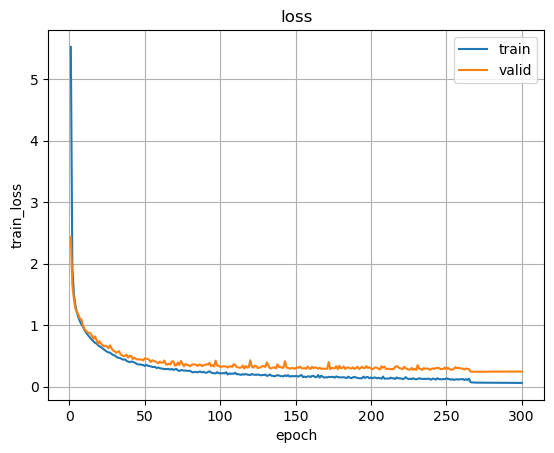

In [30]:
df_to_plot = df.loc[(df['loss_horizon']==1) & (df['beta']==1.0)]

plt.figure()
ax = sns.lineplot(
    data=df_to_plot, x="epoch", y='train_loss', label='train'
)
sns.lineplot(
    data=df_to_plot, x="epoch", y='valid_loss', label='valid', ax=ax
)
ax.set_title(f"loss")
plt.grid()

plt.show()

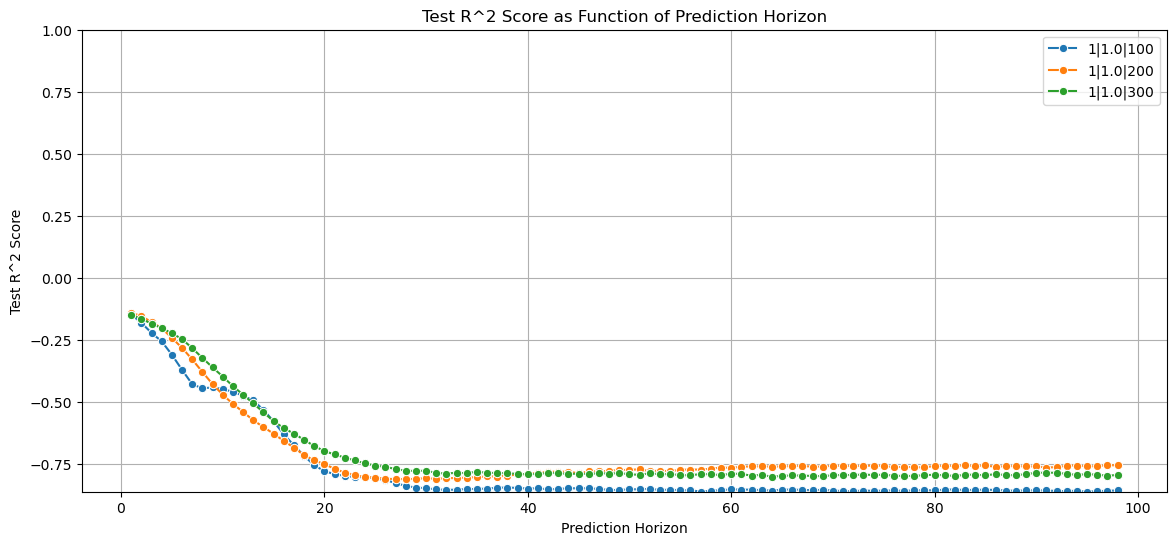

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(14, 6))

max_pred_horizon = 100

d = [
    [1, 1.0, 100],
    [1, 1.0, 200],
    [1, 1.0, 300],
    # 6: [0.5, 294],
    # 7: [0.75, 166]
]

y_lim = 1

for e in d:
    specified_loss_horizon = e[0]
    specified_beta = e[1]     
    specified_epoch = e[2]
    
    filtered_df = df[
        (df['loss_horizon'] == specified_loss_horizon) & 
        (df['beta'] == specified_beta) & 
        (df['epoch'] == specified_epoch)
    ]
    
    mean_r2_scores = filtered_df[[col for col in filtered_df.columns if col.startswith('r2_test_h_')]].mean()
    std_r2_scores = filtered_df[[col for col in filtered_df.columns if col.startswith('r2_test_h_')]].std()
    
    # Preparing data for plotting
    horizons = [int(col.split('_')[-1]) for col in mean_r2_scores.index]
    mean_scores = mean_r2_scores.values
    std_scores = std_r2_scores.values
    
    # # Plotting
    sns.lineplot(x=horizons[:max_pred_horizon], y=mean_scores[:max_pred_horizon], marker='o', linestyle='-', 
                 label=f'{specified_loss_horizon}|{specified_beta}|{specified_epoch}')
    plt.fill_between(
        horizons[:max_pred_horizon], 
        mean_scores[:max_pred_horizon] - std_scores[:max_pred_horizon], 
        mean_scores[:max_pred_horizon] + std_scores[:max_pred_horizon], alpha=0.2)

    if np.min(mean_scores[:max_pred_horizon]) < y_lim:
        y_lim = np.min(mean_scores[:max_pred_horizon])

plt.xlabel('Prediction Horizon')
plt.ylabel('Test R^2 Score')
plt.title(f'Test R^2 Score as Function of Prediction Horizon')
plt.grid(True)

plt.legend()
plt.ylim([max(-1,y_lim),1])

plt.show()

## old

In [47]:
epoch = 2
for lip_c in ['max_grad_train', 'max_grad_test', 'max_grad_random', 'spectral']:
    lip_df_pivot = df.loc[df['epoch']==epoch].pivot(index="loss_horizon", columns="beta", values=lip_c)
    plt.figure()
    ax = sns.heatmap(lip_df_pivot, annot=True)
    ax.set_title(lip_c)
    plt.savefig(f"artifacts/{lip_c}_{epoch}.jpg")
plt.show()

ValueError: Index contains duplicate entries, cannot reshape

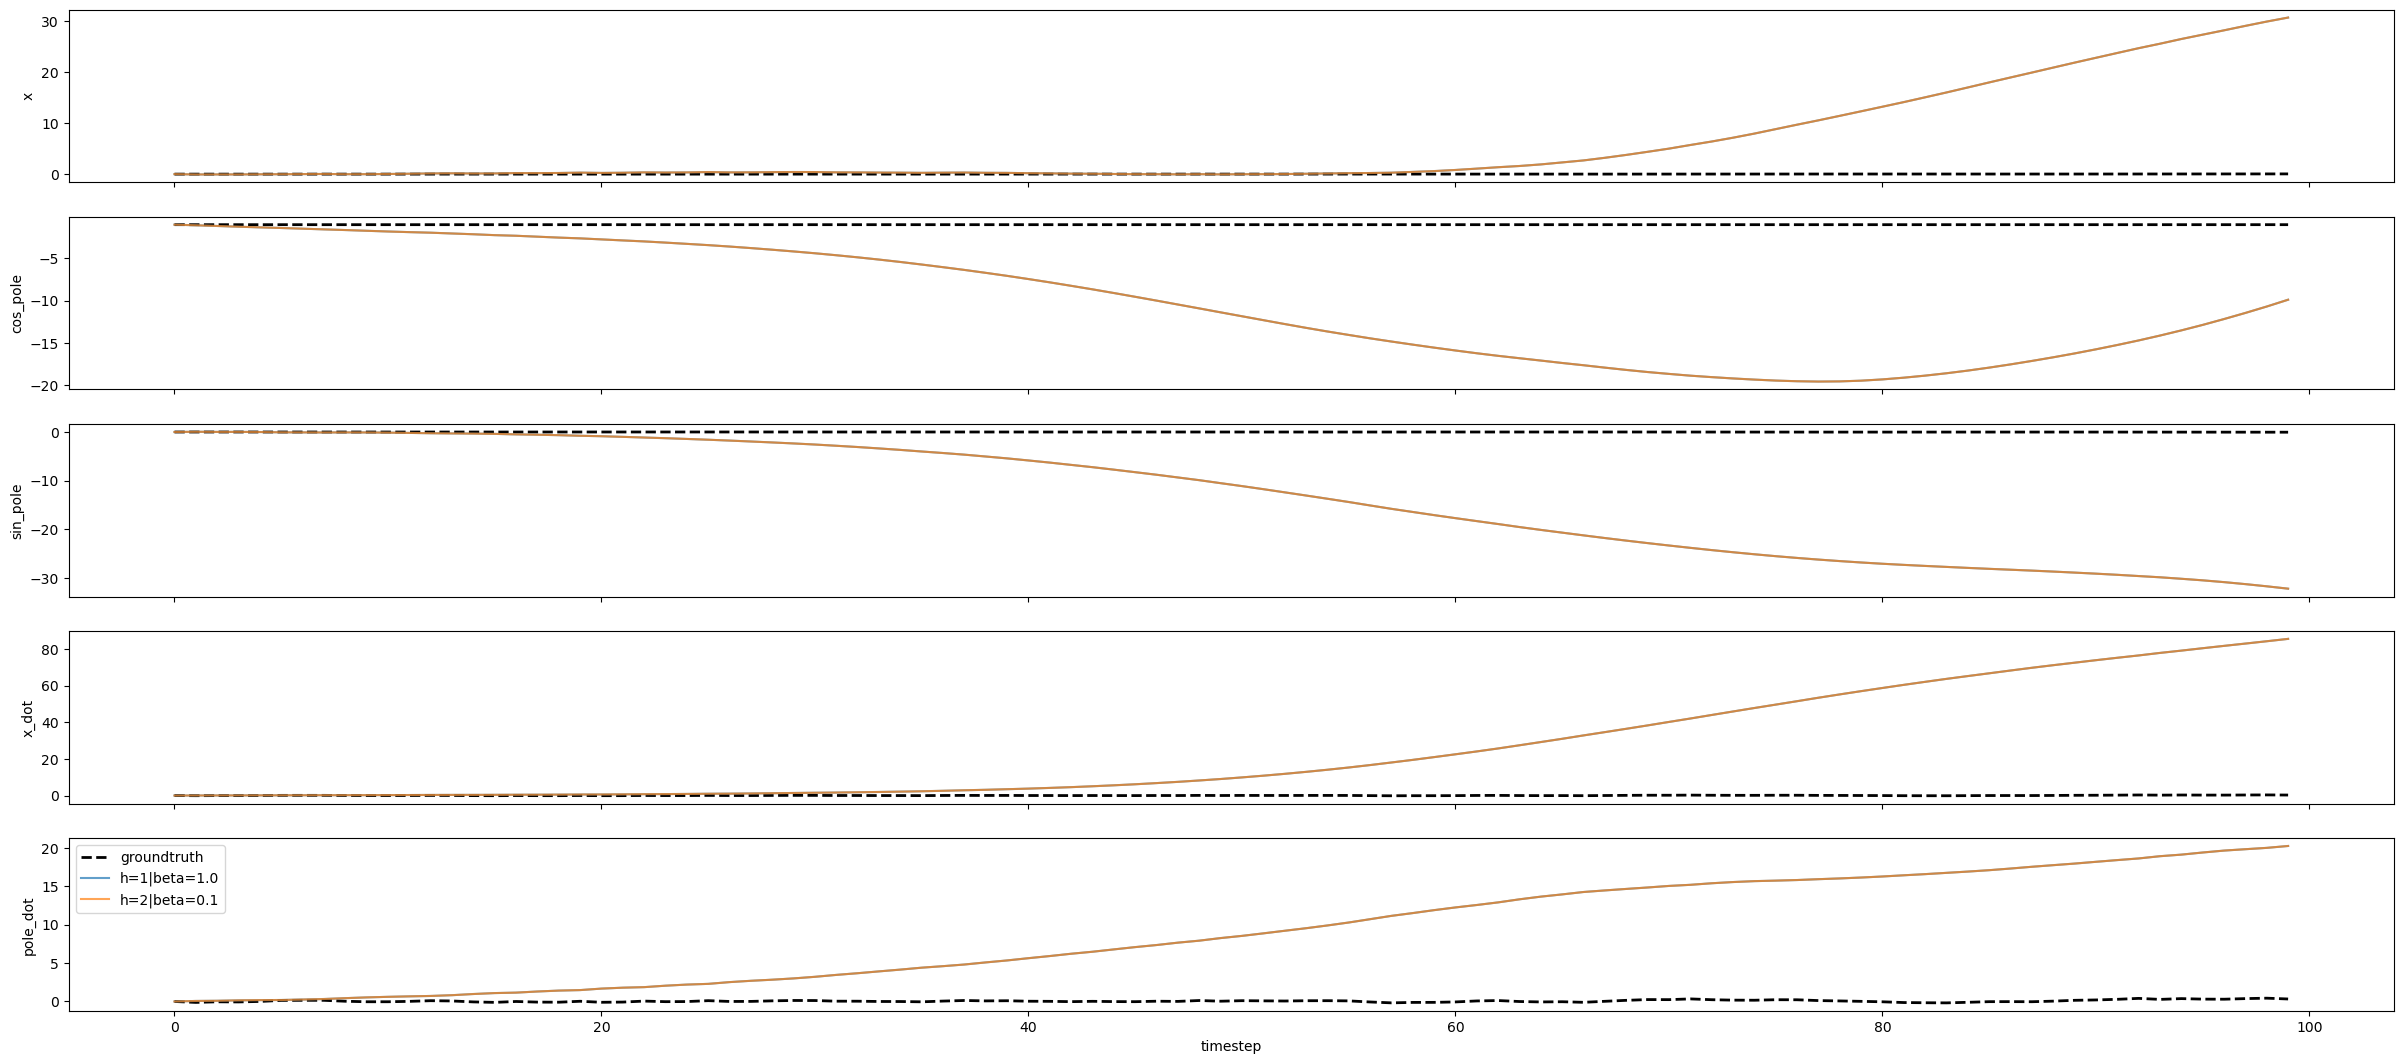

In [39]:
# [0.1, 0.25, 0.5, 0.75, 0.9, 1.0, 5.0, 20.0]
to_plot = {
    1: [1.0],
    2: [0.1,],
    # 3: [0.1, 1.0],
}

max_plot_horizon = 100

# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(30,13))

x_points = np.arange(len(groundtruth))
for dim in range(5):
    ax = eval(f"ax{dim+1}")
    ax.plot(x_points[:max_plot_horizon], np.stack(groundtruth)[:,dim][:max_plot_horizon], 'k--', label='groundtruth', linewidth=2)
    for loss_horizon, betas in to_plot.items():
        for beta in betas:
            ax.plot(x_points[:max_plot_horizon], np.stack(all_predictions[loss_horizon][beta])[:,dim][:max_plot_horizon], label=f'h={loss_horizon}|beta={beta}', alpha=.7)
    ax.set_ylabel(f"{_target_column_observation_names[dim]}")
ax.set_xlabel("timestep")
ax.legend()
plt.show()

In [34]:
df_to_plot

,epoch,loss,train/valid,loss_horizon,beta,max_grad
0,1,0.001348,train,2,0.1,0.00164
0,1,0.001769,valid,2,0.1,0.00164
0,1,0.000725,train,3,0.1,0.00475
0,1,0.000420,valid,3,0.1,0.00475


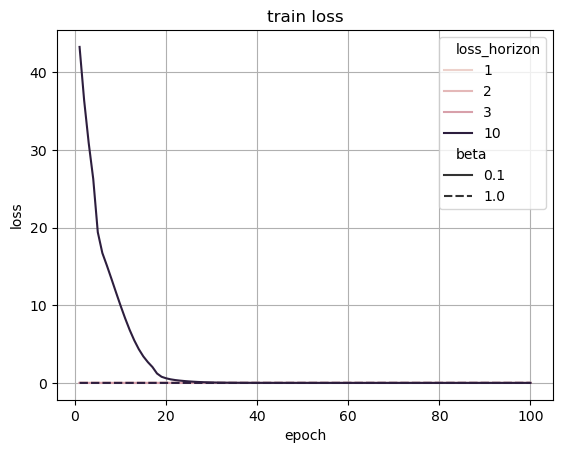

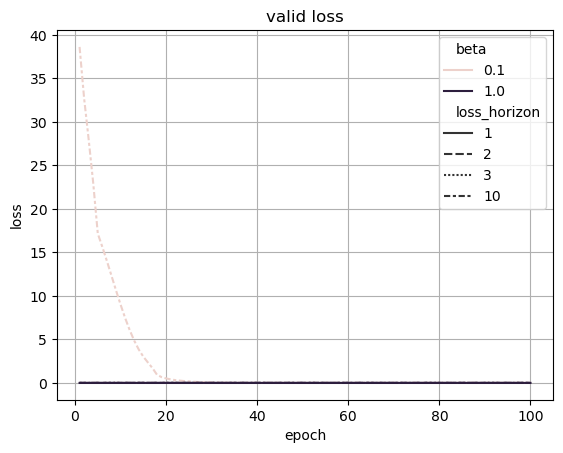

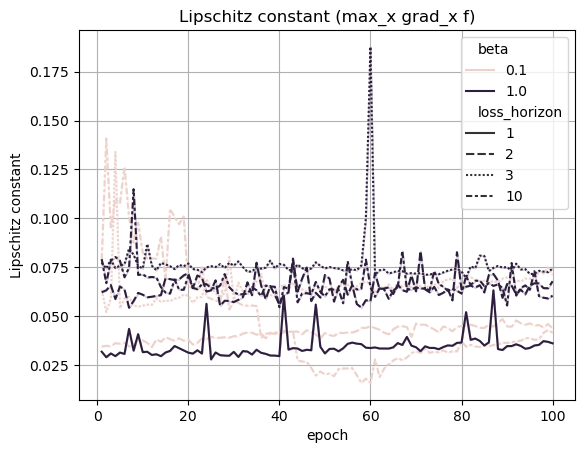

In [77]:
df_to_plot = df.loc[df['loss_horizon'].isin([1,2,3,10]) & df['beta'].isin([0.1, 1.0])]

plt.figure()

ax = sns.lineplot(
    data=df_to_plot.loc[df_to_plot['train/valid']=='train'], x="epoch", y='loss', style='beta', hue='loss_horizon',
)

ax.set_title(f"train loss")

plt.grid()

plt.figure()

ax = sns.lineplot(
    data=df_to_plot.loc[df_to_plot['train/valid']=='valid'], x="epoch", y='loss', style='loss_horizon', hue='beta',
)

ax.set_title(f"valid loss")

plt.grid()

plt.figure()

ax = sns.lineplot(
    data=df_to_plot, x="epoch", y='max_grad', style='loss_horizon', hue='beta'
)

plt.xlabel("epoch")
plt.ylabel("Lipschitz constant")
plt.title("Lipschitz constant (max_x grad_x f)")

plt.grid()

plt.show()

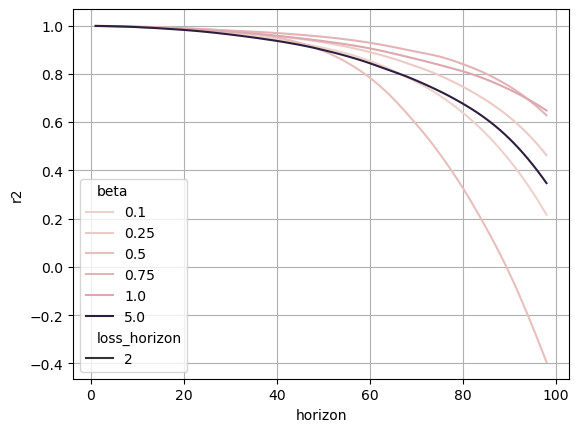

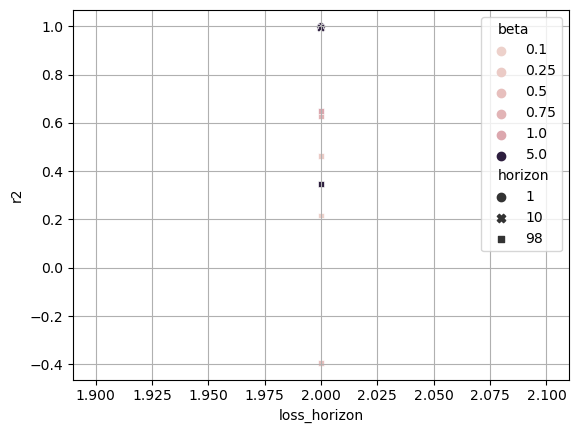

In [10]:
r2_to_plot = r2_df.loc[(r2_df['loss_horizon'].isin([2])) & (r2_df['beta'].isin([0.1, 0.25, 0.5, 0.75, 1.0, 5.0])) & (r2_df['horizon']<=100)]

plt.figure()
ax = sns.lineplot(
    data=r2_to_plot, x="horizon", y='r2', style='loss_horizon', hue='beta'
)
ax.grid(True)
# ax.set_ylim([0,1])

plt.figure()
ax = sns.scatterplot(
    data=r2_to_plot.loc[r2_to_plot['horizon'].isin([1,10,98])], x="loss_horizon", y='r2', style='horizon', hue='beta'
)
ax.grid(True)

plt.show()

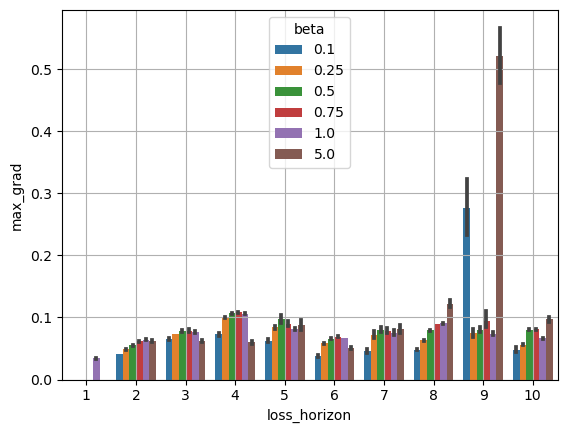

In [61]:
plt.figure()
ax = sns.barplot(
    data=df, x="loss_horizon", y='max_grad', hue='beta'
)
ax.grid(True)
plt.show()

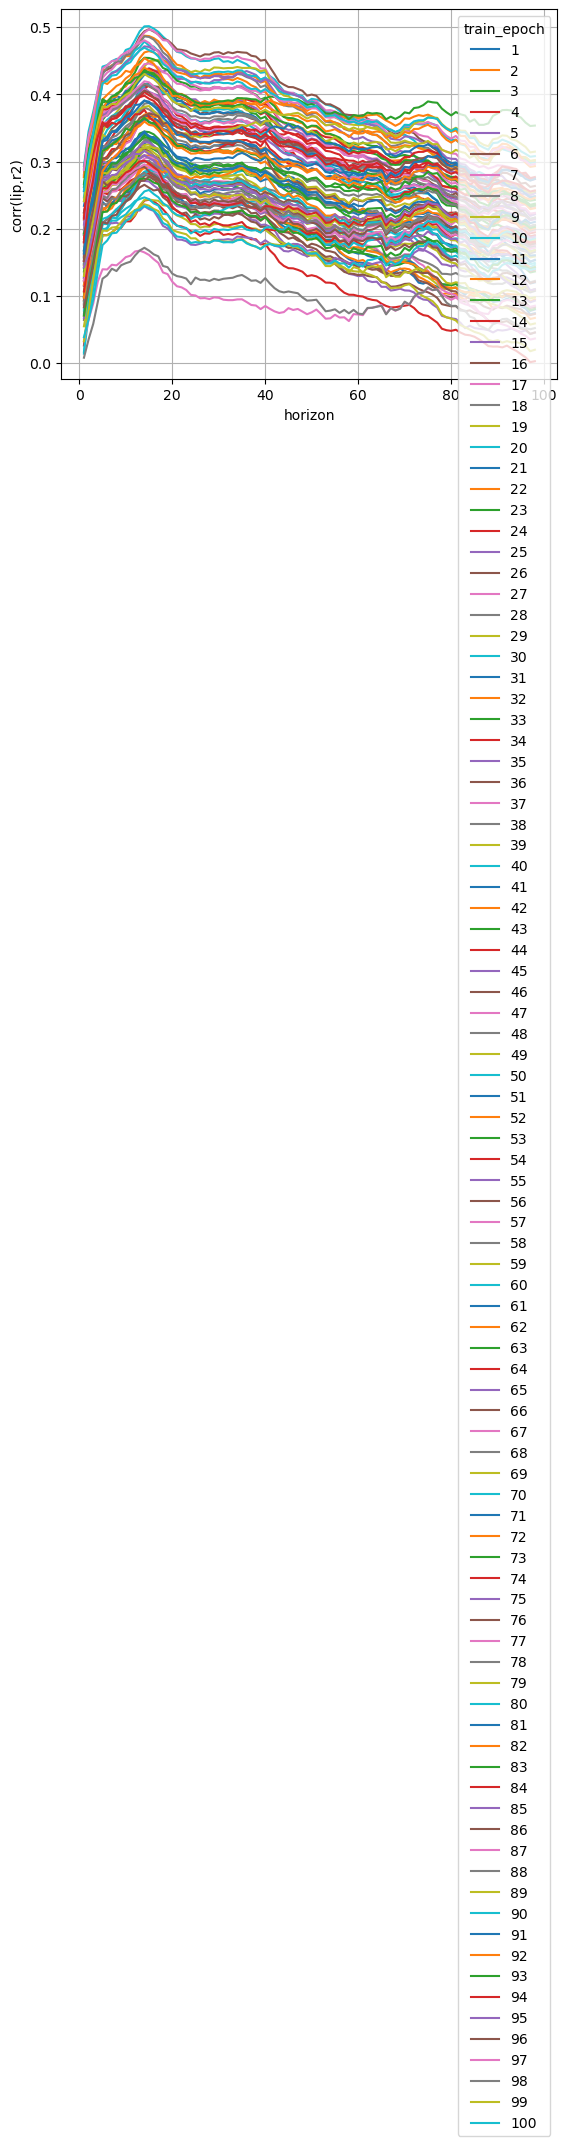

In [74]:
from scipy import stats

plt.figure()
# for train_epoch in [1,5, 7, 8, 9, 10,11, 50, 75, 90, 100]:
for train_epoch in range(1,101):
    lip = df.loc[df['epoch']==train_epoch][['loss_horizon', 'max_grad']].drop_duplicates()['max_grad'].to_numpy().flatten()
    corr = []
    for horizon in range(1, 99):
        r2 = r2_df.loc[r2_df['horizon']==horizon]['r2'].to_numpy().flatten()ls        # print(f"size r2: {r2.shape}, lip size: {lip.shape}")
        corr.append(stats.spearmanr(lip, r2)[0])

    plt.plot(np.arange(1,len(corr)+1), corr, label=f'{train_epoch}')

plt.grid()

plt.legend(title='train_epoch')

plt.xlabel('horizon')
plt.ylabel('corr(lip,r2)')

plt.show()